In [32]:
import tensorflow as tf
import os
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras_preprocessing import image
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

current_path = os.path.join(os.getcwd(), '..')
base_path = f'{current_path}/data/raw/cats_and_dogs_filtered'
train_path = os.path.join(f'{base_path}/train/')
validation_path = os.path.join(f'{base_path}/validation/')

try:
    os.mkdir(f'{current_path}/data/processed')
except Exception:
    pass

In [4]:
# (train / validation)
dogs_dataset = (os.path.join(train_path, 'dogs'),
                os.path.join(validation_path, 'dogs'))
cats_dataset = (os.path.join(train_path, 'cats'),
                os.path.join(validation_path, 'cats'))



In [5]:
# Create the base model from the pre-trained model MobileNet V2
xception = tf.keras.applications.Xception(include_top=False,
                                        weights='imagenet',
                                        pooling='avg')


83689472/83683744 [==============================] - 74s 1us/step


In [6]:
model = tf.keras.Sequential()
model.add(xception)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))


In [7]:
for layer in model.layers[:-4]:
    layer.trainable = False
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 22,961,706
Trainable params: 2,100,226
Non-trainable params: 20,861,480
_________________________________________________________________


In [8]:
def extract_features(img_dir, label):
    img = cv2.imread(img_dir)
    img = cv2.resize(img, (299, 299))
    return [preprocess_input(img), label]

def extract_data(dataset, label):
    features = []
    for img_path in tqdm(os.listdir(dataset)):
        img_dir = os.path.join(dataset, img_path)
        features.append(extract_features(img_dir, label))
    return features

train_dataset = pd.concat([pd.DataFrame(x) for x in [
    extract_data(dogs_dataset[0], 'dog'),
    extract_data(cats_dataset[0], 'cat')
]])


val_dataset = pd.concat([pd.DataFrame(x) for x in [
    extract_data(dogs_dataset[1], 'dog'),
    extract_data(cats_dataset[1], 'cat')
]])

100%|██████████| 500/500 [00:05<00:00, 95.06it/s] 


In [9]:

def fix_X_array(raw_data):
    return np.concatenate(raw_data).reshape((raw_data.shape[0], 299, 299, 3))

def fix_Y_array(raw_data):
    ravel = np.ravel(raw_data.iloc[:,1:].to_numpy())
    y_labels = []
    for y in ravel:
        y_labels.append(1 if y == 'dog' else 0)
    return np.array(y_labels)

X_train = fix_X_array((train_dataset.iloc[:,0]).to_numpy())
y_train = tf.keras.utils.to_categorical(fix_Y_array(train_dataset))

X_val = fix_X_array((val_dataset.iloc[:,0]).to_numpy())
y_val = tf.keras.utils.to_categorical(fix_Y_array(val_dataset))


In [10]:
X_train.shape

(2000, 299, 299, 3)

In [11]:
X_val.shape

(1000, 299, 299, 3)

In [12]:
train_Y_df = pd.DataFrame('cat' if 'cat.' in Y else 'dog' for Y in train_dataset.loc[:, 0])
validation_Y_df = pd.DataFrame('cat' if 'cat.' in Y else 'dog' for Y in val_dataset.loc[:, 0])

model.fit(X_train, y_train,
         batch_size=128,
          epochs=5,
          verbose=1,
          validation_split=0.2)


/Users/lucaspaim/deep_learning_cats_and_dogs_study/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.
/Users/lucaspaim/deep_learning_cats_and_dogs_study/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


Train on 1600 samples, validate on 400 samples
Epoch 1/5
1600/1600 [==============================] - 1476s 922ms/sample - loss: 0.1936 - accuracy: 0.9137 - val_loss: 0.0140 - val_accuracy: 0.9950
Epoch 2/5
1600/1600 [==============================] - 1217s 761ms/sample - loss: 0.0898 - accuracy: 0.9744 - val_loss: 0.0230 - val_accuracy: 0.9950
Epoch 3/5
1600/1600 [==============================] - 2011s 1s/sample - loss: 0.0218 - accuracy: 0.9944 - val_loss: 0.0225 - val_accuracy: 0.9950
Epoch 4/5
1600/1600 [==============================] - 1864s 1s/sample - loss: 0.0108 - accuracy: 0.9962 - val_loss: 0.0198 - val_accuracy: 0.9950
Epoch 5/5
1600/1600 [==============================] - 1533s 958ms/sample - loss: 0.0115 - accuracy: 0.9956 - val_loss: 0.0311 - val_accuracy: 0.9950


In [17]:
# acc = model.score(X_val, y_val)
# print(f'Acurácia Fine Tunning Validação: {acc}')

all_classes = ['cat', 'dog']
predictions = model.predict(X_val)


In [31]:
# evaluate model
_, acc = model.evaluate(X_val, y_val, verbose=0)
print('Final Accuracy: > %.3f' % (acc * 100.0))


Final Accuracy: > 99.400


In [28]:
predictions
y_pred = (predictions > 0.5) 
y_pred

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

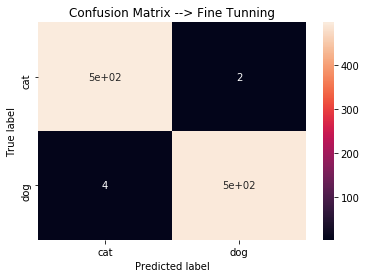

In [33]:
cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))
df_cm = pd.DataFrame(cm, index=[all_classes], columns=all_classes)
sns.heatmap(df_cm, annot=True)
plt.title(f'Confusion Matrix --> Fine Tunning')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()